In [437]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import jpholiday

import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [438]:
df = pd.read_csv('demand.csv')
df.head()
df = df.set_index('datetime')
df.index = pd.to_datetime(df.index , format='%m/%d/%Y %H:%M')
df = df.rename(columns={ 'actual_performance(10000 kW)': 'demand'})

In [439]:
prefecture_files = {
    'osaka': 'osaka.csv',
    'hikone': 'hikone.csv',
    'kyoto': 'kyoto.csv',
    'kobe': 'kobe.csv',
    'shionomisaki': 'shionomisaki.csv',
    'toyooka': 'toyooka.csv',
    'wakayama': 'wakayama.csv'
}
weather_weights = {
    'osaka': 0.25,
    'hikone': 0.15,
    'kyoto': 0.2,
    'kobe': 0.15,
    'shionomisaki': 0.1,
    'toyooka': 0.1,
    'wakayama': 0.05
}

wind_mapping = {
    "北": 0,
    "北北東": 22.5,
    "北東": 45,
    "東北東": 67.5,
    "東": 90,
    "東南東": 112.5,
    "南東": 135,
    "南南東": 157.5,
    "南": 180,
    "南南西": 202.5,
    "南西": 225,
    "西南西": 247.5,
    "西": 270,
    "西北西": 292.5,
    "北西": 315,
    "北北西": 337.5,
    "静穏": np.nan,      # Calm, no meaningful wind direction
    "×": np.nan,         # Invalid or missing data
    "北北西 )": 337.5,    # Variant of "北北西"
    "西 )": 270,         # Variant of "西"
    "東北東 )": 67.5      # Variant of "東北東"
}

prefecture_dfs = {}
for prefecture, file in prefecture_files.items():
    pdf = pd.read_csv(file)
    pdf['datetime'] = pd.to_datetime(pdf['datetime'])
    # pdf = pdf.set_index('datetime')
    # print(pdf['wind_direction'])
    helo = pdf.copy()
    pdf['wind_direction'] = pdf['wind_direction'].map(wind_mapping)
    # print(pdf['wind_direction'][pdf['wind_direction'].isnull()])
    # print(helo['wind_direction'][pdf['wind_direction'].isnull()].unique())
    

    pdf['wind_direction'] = pd.to_numeric(pdf['wind_direction'], errors='coerce')
    prefecture_dfs[prefecture] = pdf
    # pdf['wind_direction']
    
weather_vars = [
    'precipitation',
    'temperature',
    'dew_point_temperature',
    'humidity',
    'wind_speed',
    'wind_direction',
    'snowfall'
]



In [440]:
base_pref = 'osaka'
aggregated_weather = prefecture_dfs[base_pref][['datetime']].copy()

# Initialize columns
for var in weather_vars:
    aggregated_weather[var] = 0.0


In [441]:
# Accumulate weighted sums
for prefecture, w in weather_weights.items():
    # Merge on datetime
    merged_temp = pd.merge(
        aggregated_weather,
        prefecture_dfs[prefecture],
        on='datetime',
        how='left',
        suffixes=('', '_temp')
    )
    
    # print(merged_temp['wind_direction'])
    # For each weather variable, add weighted value
    for var in weather_vars:
        merged_temp[var] = merged_temp[var] + w * merged_temp[f'{var}_temp']

    # Clean up extra columns
    drop_cols = [f'{var}_temp' for var in weather_vars]
    merged_temp.drop(columns=drop_cols, inplace=True)

    aggregated_weather = merged_temp

# Round wind_direction if needed
# aggregated_weather['wind_direction'] = aggregated_weather['wind_direction'].round().astype(int)
# aggregated_weather['wind_direction'].isnull().sum()

In [442]:
#  Merge the Aggregated Weather with Demand
merged_df = pd.merge(df, aggregated_weather, on='datetime', how='left')

merged_df

,datetime,demand,precipitation,temperature,dew_point_temperature,humidity,wind_speed,wind_direction,snowfall
0,2021-01-01 00:00:00,1571,0.050,1.725,-3.825,67.35,4.055,227.250,0.1
1,2021-01-01 01:00:00,1492,0.150,1.815,-3.645,67.75,3.575,217.125,0.2
2,2021-01-01 02:00:00,1453,0.050,1.715,-3.695,67.95,3.530,213.750,0.0
3,2021-01-01 03:00:00,1412,0.100,1.370,-3.685,69.75,3.465,221.625,0.2
4,2021-01-01 04:00:00,1358,0.050,1.575,-3.265,70.80,3.330,252.000,0.0
...,...,...,...,...,...,...,...,...,...
26275,2023-12-31 19:00:00,1427,0.500,10.610,4.310,65.95,5.040,250.875,0.0
26276,2023-12-31 20:00:00,1392,0.650,10.360,4.170,65.85,5.500,245.250,0.0
26277,2023-12-31 21:00:00,1348,0.350,9.735,4.910,72.60,4.730,258.750,0.0
26278,2023-12-31 22:00:00,1288,1.125,9.435,5.435,76.40,4.720,253.125,0.0


In [443]:
df = merged_df.copy()
df = df.set_index('datetime')
df

,demand,precipitation,temperature,dew_point_temperature,humidity,wind_speed,wind_direction,snowfall
datetime,,,,,,,,
2021-01-01 00:00:00,1571,0.050,1.725,-3.825,67.35,4.055,227.250,0.1
2021-01-01 01:00:00,1492,0.150,1.815,-3.645,67.75,3.575,217.125,0.2
2021-01-01 02:00:00,1453,0.050,1.715,-3.695,67.95,3.530,213.750,0.0
2021-01-01 03:00:00,1412,0.100,1.370,-3.685,69.75,3.465,221.625,0.2
2021-01-01 04:00:00,1358,0.050,1.575,-3.265,70.80,3.330,252.000,0.0
...,...,...,...,...,...,...,...,...
2023-12-31 19:00:00,1427,0.500,10.610,4.310,65.95,5.040,250.875,0.0
2023-12-31 20:00:00,1392,0.650,10.360,4.170,65.85,5.500,245.250,0.0
2023-12-31 21:00:00,1348,0.350,9.735,4.910,72.60,4.730,258.750,0.0


In [444]:
def add_lags(df):

    df = df.copy()
    target_map = df['demand'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('1hr')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('24hr')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('7d')).map(target_map)
    df['lag4'] = (df.index - pd.Timedelta('364d')).map(target_map)

    df.fillna(0, inplace=True)
    return df


In [445]:
df = add_lags(df)

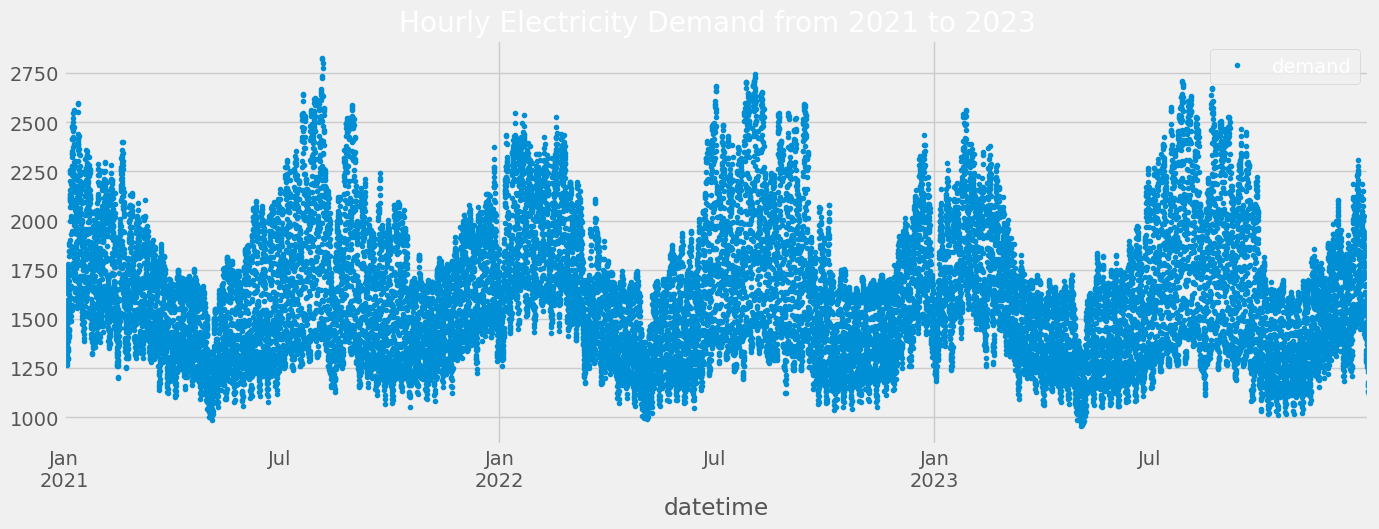

In [446]:
df.plot(style = '.', figsize = (15,5), y= 'demand', color= color_pal[0], title = 'Hourly Electricity Demand from 2021 to 2023')
plt.show()

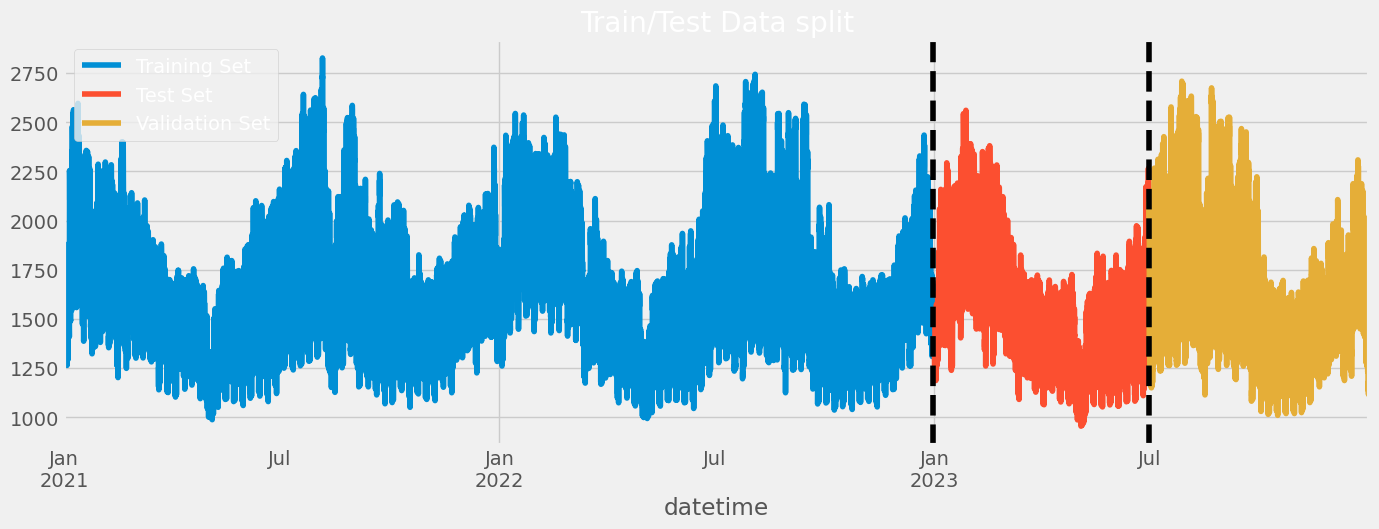

In [447]:
#Train/Test split

train = df.loc[df.index <= '12-31-2022']
test = df.loc[(df.index > '01-01-2023')&(df.index <= '06-30-2023')]
validate = df.loc[df.index > '06-30-2023']

fig, ax = plt.subplots(figsize = (15,5))
train.plot(ax = ax, y= 'demand', label = 'Training Set', title = 'Train/Test Data split')
test.plot(ax = ax, y= 'demand', label = 'Test Set')
validate.plot(ax = ax, y= 'demand', label = 'Validation Set')
ax.axvline('12-31-2022', color = 'black', ls = '--')
ax.axvline('06-30-2023', color = 'black', ls = '--')
plt.show()

<Axes: title={'center': 'Data of a week'}, xlabel='datetime'>

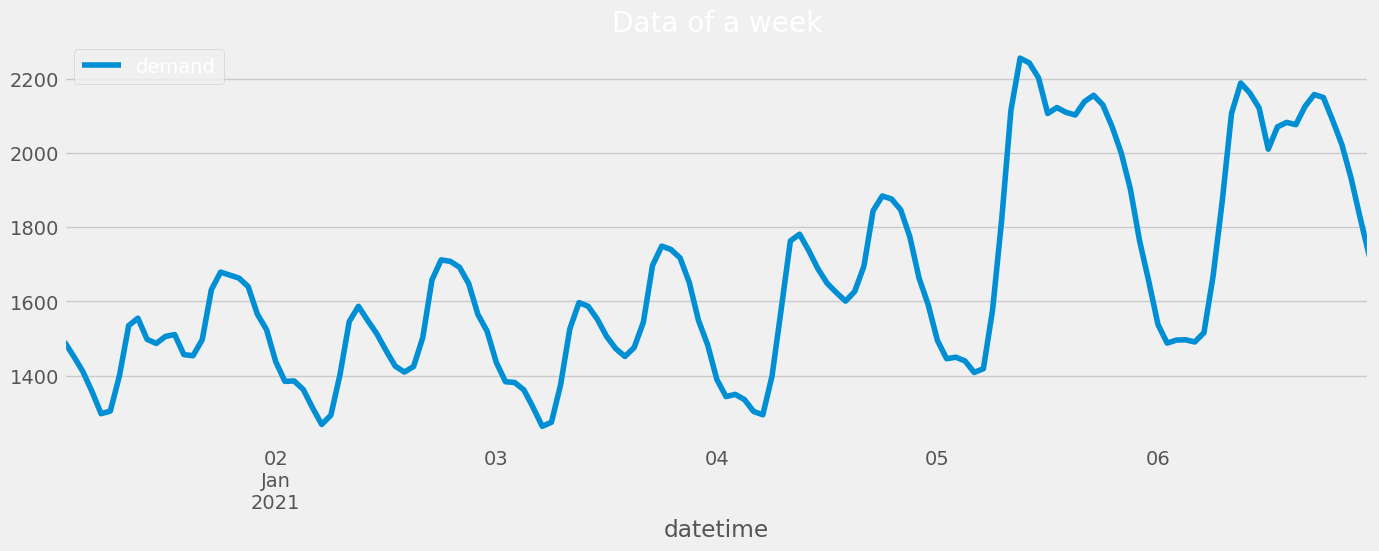

In [448]:
df.loc[(df.index > '01-01-2021') & (df.index < '01-07-2021')].plot(figsize = (15,5),y= 'demand', title = 'Data of a week')

In [449]:
#Feature Creation
def create_features(df):

    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week

    # Add rolling lag features for demand
    window_size = 24  # 24-hour rolling window
    
    # Rolling mean of demand over the past 24 hours
    df['rolling_mean_24h'] = df['demand'].rolling(window=window_size, min_periods=1).mean()
    
    # Rolling standard deviation of demand over the past 24 hours
    df['rolling_std_24h'] = df['demand'].rolling(window=window_size, min_periods=1).std()
    
    # Rolling minimum and maximum of demand over the past 24 hours
    df['rolling_min_24h'] = df['demand'].rolling(window=window_size, min_periods=1).min()
    df['rolling_max_24h'] = df['demand'].rolling(window=window_size, min_periods=1).max()
    
    # Rolling median of demand over the past 24 hours
    df['rolling_median_24h'] = df['demand'].rolling(window=window_size, min_periods=1).median()

    # Exponential moving average of demand over the past 24 hours
    df['ema_24h'] = df['demand'].ewm(span=window_size, adjust=False).mean()
    # Difference in demand from the previous hour
    df['demand_diff_1h'] = df['demand'].diff(1)
    
    # Difference in demand from the previous day
    df['demand_diff_24h'] = df['demand'].diff(24)
    
    # Fill NaN values created by differencing
    df.fillna(0, inplace=True)
    return df

df = create_features(df)

In [450]:
# Creating holiday/weekend features
def create_holiday_features(df):

    df = df.copy()
    
    # Basic holiday indicators
    df['is_holiday'] = df.index.map(lambda x: jpholiday.is_holiday(x)).astype(int)
    df['is_weekend'] = df.index.dayofweek.isin([5,6]).astype(int)
    
    return df

df = create_holiday_features(df)

Text(0.5, 1.0, 'Demand by Hour')

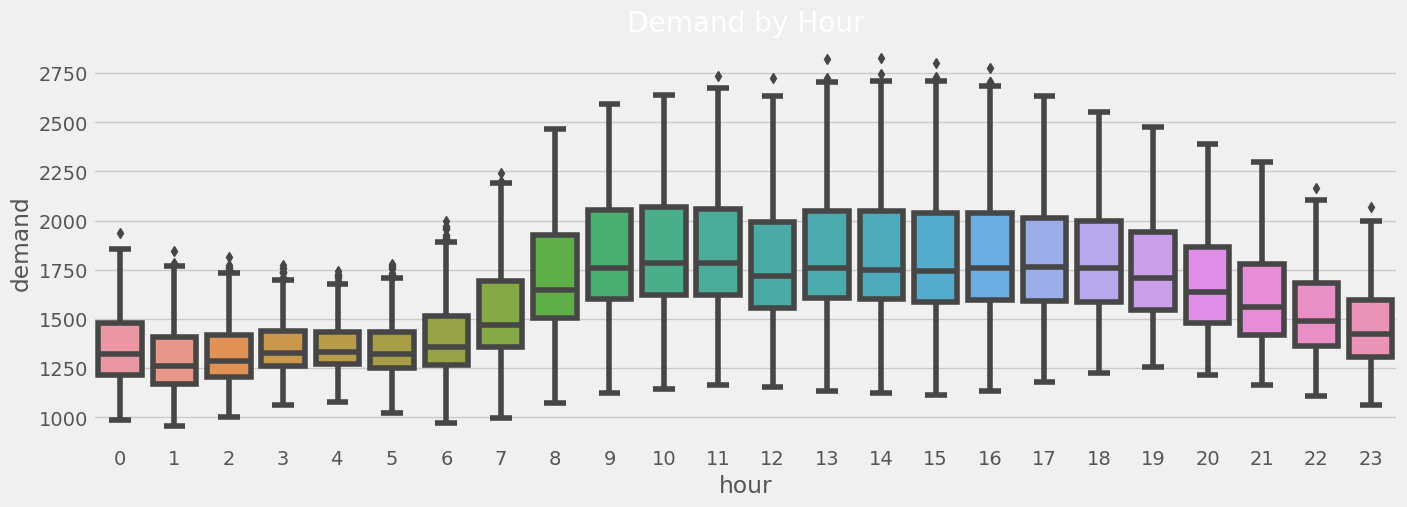

In [451]:
#Visualise the Feature/Target Relationship
fig, ax = plt.subplots(figsize = (15,5))
sns.boxplot(data = df, x = 'hour', y='demand')
ax.set_title('Demand by Hour')

Text(0.5, 1.0, 'Demand by month')

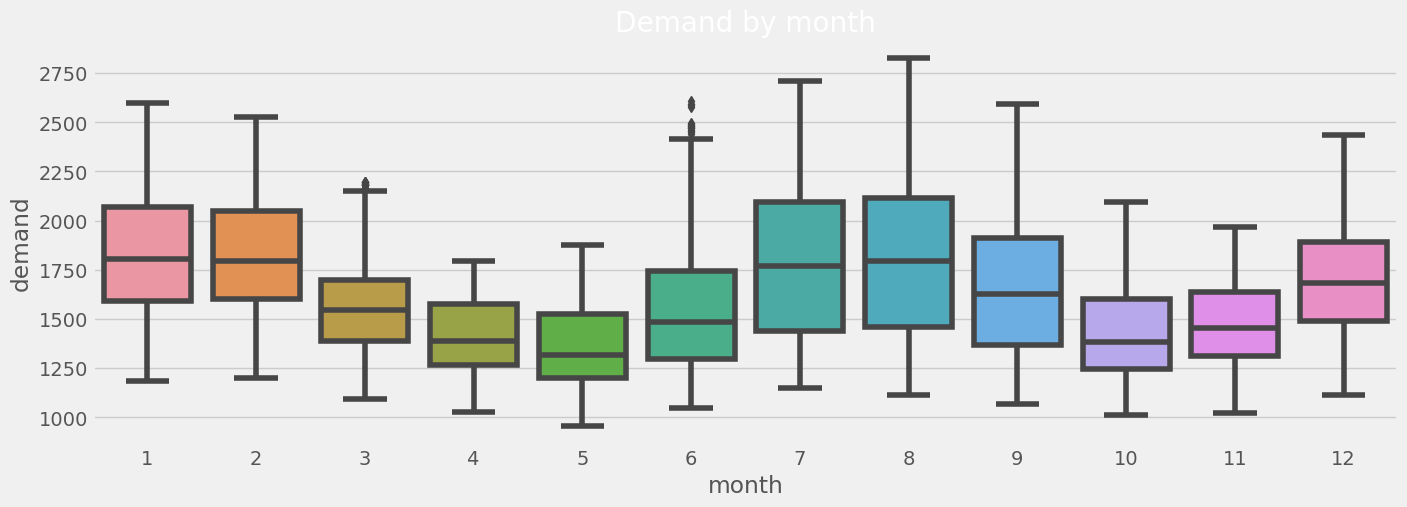

In [452]:
#Visualise the Feature/Target Relationship
fig, ax = plt.subplots(figsize = (15,5))
sns.boxplot(data = df, x = 'month', y='demand')
ax.set_title('Demand by month')

In [453]:
df.columns

Index(['demand', 'precipitation', 'temperature', 'dew_point_temperature',
       'humidity', 'wind_speed', 'wind_direction', 'snowfall', 'lag1', 'lag2',
       'lag3', 'lag4', 'hour', 'dayofweek', 'quarter', 'month', 'year',
       'dayofyear', 'dayofmonth', 'weekofyear', 'rolling_mean_24h',
       'rolling_std_24h', 'rolling_min_24h', 'rolling_max_24h',
       'rolling_median_24h', 'ema_24h', 'demand_diff_1h', 'demand_diff_24h',
       'is_holiday', 'is_weekend'],
      dtype='object')

In [454]:
#Creating our Model

train = create_features(train)
test = create_features(test)

train = create_holiday_features(train)
test = create_holiday_features(test)

FEATURES = ['precipitation', 'temperature', 'dew_point_temperature',
       'humidity', 'wind_speed', 'wind_direction', 'snowfall', 'lag1', 'lag2',
       'lag3', 'lag4', 'hour', 'dayofweek', 'quarter', 'month', 'year',
       'dayofyear', 'dayofmonth', 'weekofyear', 'rolling_mean_24h',
       'rolling_std_24h', 'rolling_min_24h', 'rolling_max_24h',
       'rolling_median_24h', 'ema_24h', 'demand_diff_1h', 'demand_diff_24h',
       'is_holiday', 'is_weekend']

TARGET = 'demand'

In [455]:
X_train = train[FEATURES]
Y_train = train[TARGET]

X_test = test[FEATURES]
Y_test = test[TARGET]

In [456]:
reg = xgb.XGBRegressor(
    n_estimators=3000,
    learning_rate=0.01,
    max_depth=8,
    subsample=0.9,
    colsample_bytree=0.8,
    gamma=0.1,
    reg_alpha=0.1,
    reg_lambda=1.0,
    random_state=42,
    early_stopping_rounds=100
)

reg.fit(X_train, Y_train,
       eval_set = [(X_train, Y_train), (X_test, Y_test)],
       verbose = 100)

[0]	validation_0-rmse:323.13731	validation_1-rmse:303.70148
[100]	validation_0-rmse:121.29389	validation_1-rmse:114.90703
[200]	validation_0-rmse:46.17115	validation_1-rmse:44.88369
[300]	validation_0-rmse:18.43774	validation_1-rmse:19.57359
[400]	validation_0-rmse:8.38129	validation_1-rmse:11.02226
[500]	validation_0-rmse:4.91463	validation_1-rmse:8.36985
[600]	validation_0-rmse:3.70501	validation_1-rmse:7.50430
[700]	validation_0-rmse:3.15873	validation_1-rmse:7.14210
[800]	validation_0-rmse:2.84595	validation_1-rmse:6.94930
[900]	validation_0-rmse:2.62698	validation_1-rmse:6.83826
[1000]	validation_0-rmse:2.46861	validation_1-rmse:6.77126
[1100]	validation_0-rmse:2.33819	validation_1-rmse:6.72196
[1200]	validation_0-rmse:2.22881	validation_1-rmse:6.68144
[1300]	validation_0-rmse:2.13047	validation_1-rmse:6.65280
[1400]	validation_0-rmse:2.04297	validation_1-rmse:6.62813
[1500]	validation_0-rmse:1.96133	validation_1-rmse:6.60676
[1600]	validation_0-rmse:1.88664	validation_1-rmse:6.58

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=100,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.1, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=3000, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

<Axes: title={'center': 'Feature Importance'}>

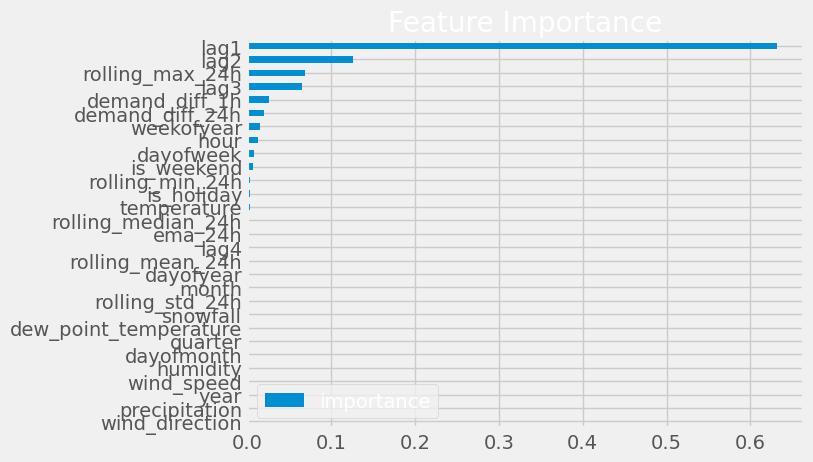

In [457]:
fimp = pd.DataFrame(data = reg.feature_importances_,
            index = reg.feature_names_in_,
            columns = ['importance'])

fimp.sort_values('importance').plot(kind = 'barh', title = 'Feature Importance')

In [458]:
test['prediction'] = reg.predict(X_test)

df = df.merge(test[['prediction']], how = 'left', left_index = True, right_index = True)

Text(0.5, 1.0, 'Raw Data and Predicted Data for the Test Set')

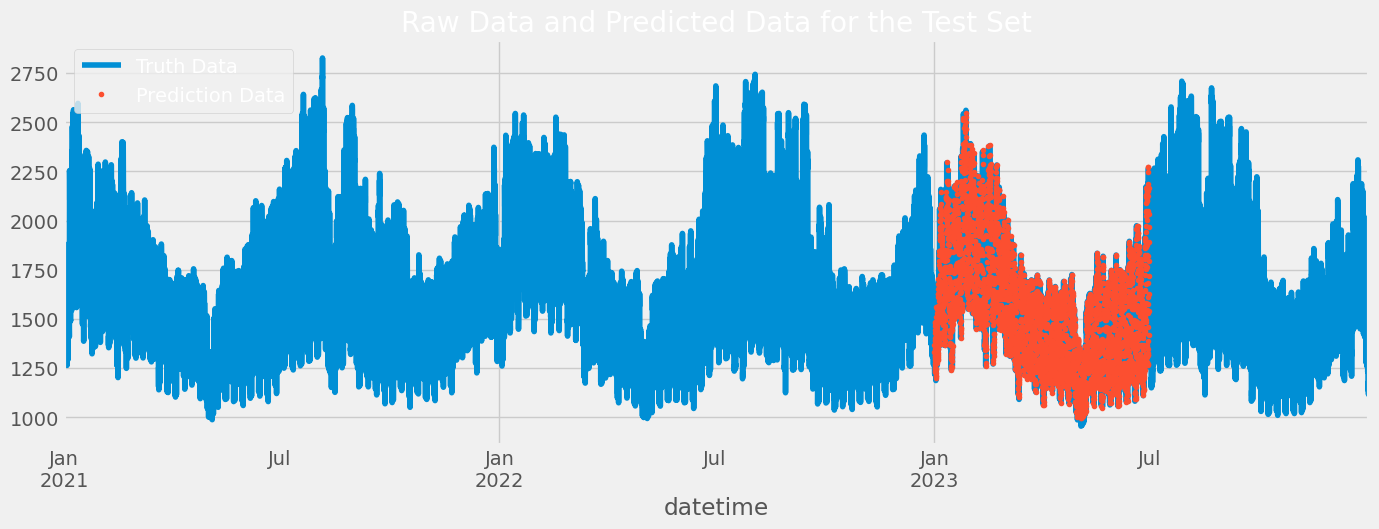

In [459]:
ax = df['demand'].plot(figsize = (15,5))
df['prediction'].plot(ax = ax, style = '.')
plt.legend(['Truth Data', 'Prediction Data'])
ax.set_title('Raw Data and Predicted Data for the Test Set')

Text(0.5, 1.0, 'Data of a week')

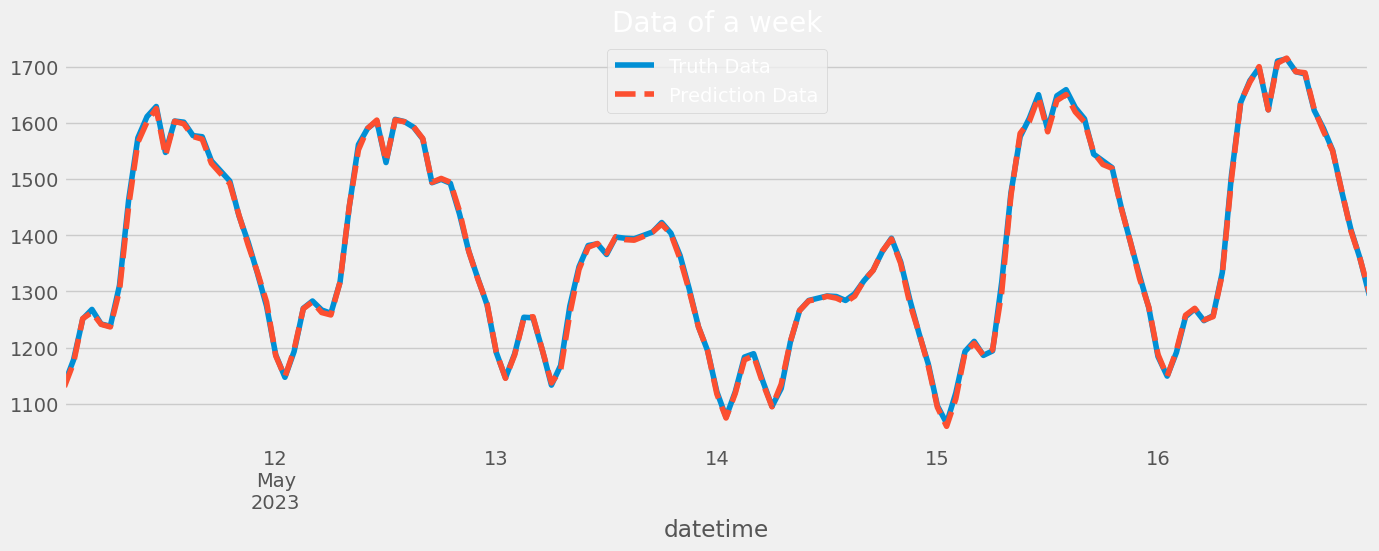

In [460]:
ax = df.loc[(df.index > '05-11-2023') & (df.index < '05-17-2023')]['demand'].plot(figsize = (15,5))
df.loc[(df.index > '05-11-2023') & (df.index < '05-17-2023')]['prediction'].plot(ax = ax, style = '--')
plt.legend(['Truth Data', 'Prediction Data'])
ax.set_title('Data of a week')

In [461]:
# Assuming y_true is the actual demand and y_pred is the predicted demand
teste = test.copy().drop(columns=['prediction'])
y_true = teste['demand']
y_pred = reg.predict(teste.drop(columns=['demand']))

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_true, y_pred)
print(f'Mean Absolute Error for the test set(MAE): {mae:.2f}')

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print(f'Root Mean Squared Error for the test set(RMSE): {rmse:.2f}')

# Mean Absolute Percentage Error (MAPE)
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(y_true, y_pred)
print(f'Mean Absolute Percentage Error for the test set(MAPE): {mape:.2f}%')

def weighted_absolute_percentage_error(y_true, y_pred):
    """
    Weighted Absolute Percentage Error (WAPE).
    
    Parameters:
    y_true (array-like): Actual values.
    y_pred (array-like): Predicted values.
    
    Returns:
    float: WAPE value.
    """
    absolute_errors = np.abs(y_true - y_pred)
    sum_absolute_errors = np.sum(absolute_errors)
    sum_actual_values = np.sum(np.abs(y_true))
    
    wape = (sum_absolute_errors / sum_actual_values) * 100
    return wape

wape = weighted_absolute_percentage_error(y_true, y_pred)
print(f'Weighted Absolute Percentage Error (WAPE): {wape:.2f}%')

Mean Absolute Error for the test set(MAE): 4.15
Root Mean Squared Error for the test set(RMSE): 6.47
Mean Absolute Percentage Error for the test set(MAPE): 0.28%
Weighted Absolute Percentage Error (WAPE): 0.27%


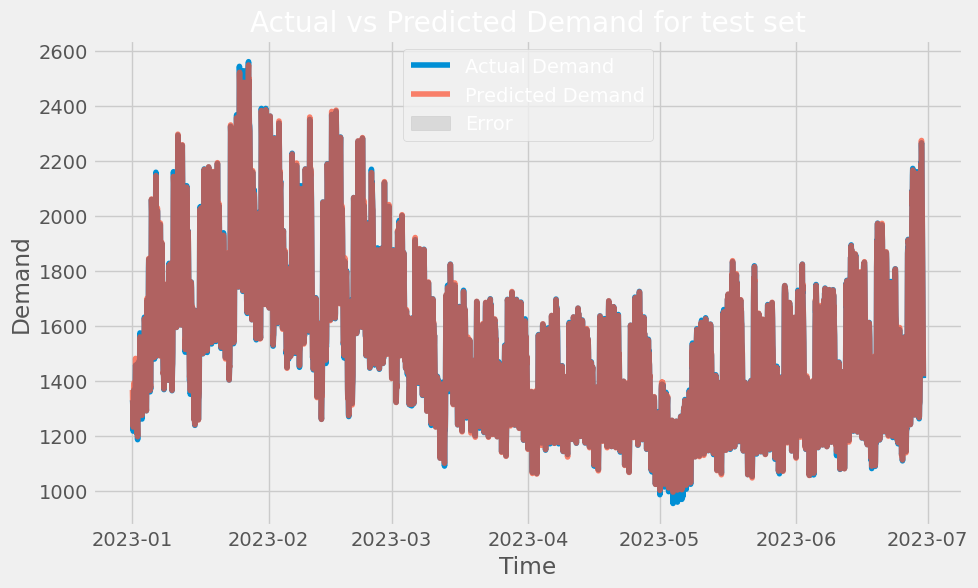

In [462]:
# Actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_true.index, y_true, label='Actual Demand')
plt.plot(y_true.index, y_pred, label='Predicted Demand', alpha=0.7)
plt.fill_between(y_true.index, y_true, y_pred, color='gray', alpha=0.2, label='Error')
plt.title('Actual vs Predicted Demand for test set')
plt.xlabel('Time')
plt.ylabel('Demand')
plt.legend()
plt.show()

In [463]:
validate = create_features(validate)
validate = create_holiday_features(validate)

validate['prediction'] = reg.predict(validate[FEATURES])
df = df.drop(columns=['prediction'])
df = df.merge(validate[['prediction']], how = 'left', left_index = True, right_index = True)

Text(0.5, 1.0, 'Raw Data and Predicted Data for the Validation set')

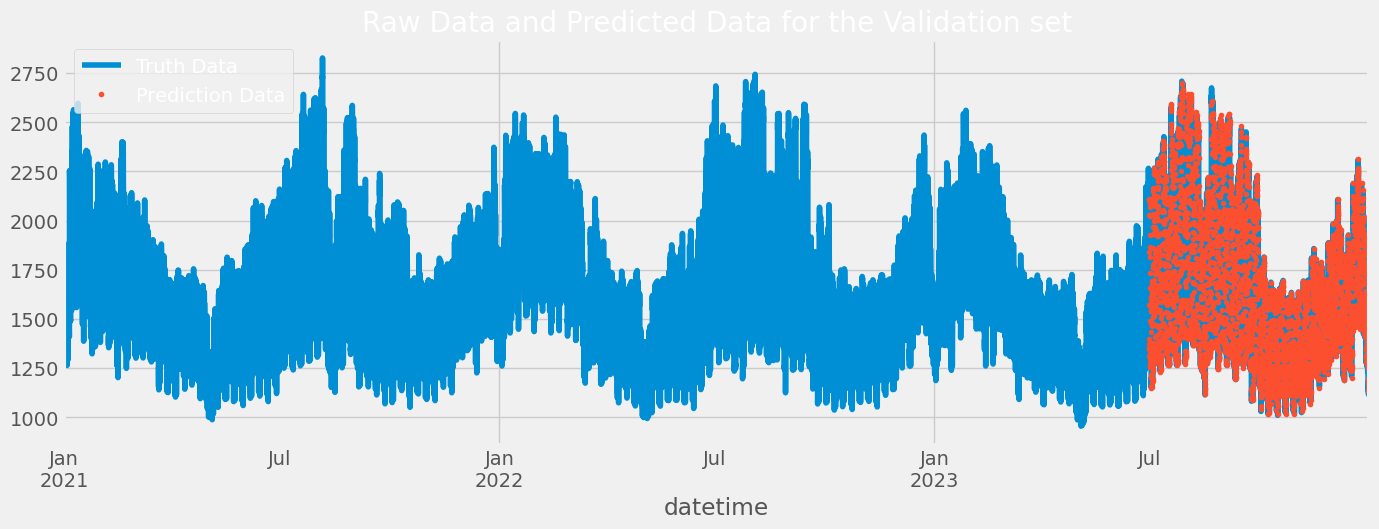

In [464]:
ax = df['demand'].plot(figsize = (15,5))
df['prediction'].plot(ax = ax, style = '.')
plt.legend(['Truth Data', 'Prediction Data'])
ax.set_title('Raw Data and Predicted Data for the Validation set')

Text(0.5, 1.0, 'Data of a week with the Validation Set')

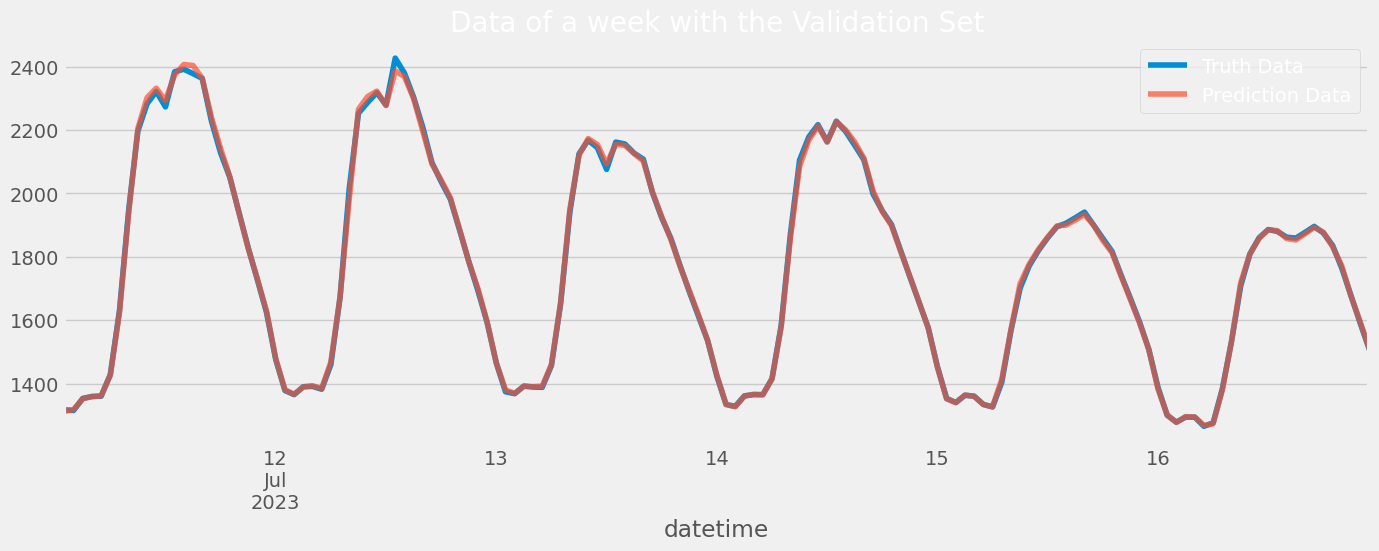

In [465]:
ax = df.loc[(df.index > '07-11-2023') & (df.index < '07-17-2023')]['demand'].plot(figsize = (15,5))
df.loc[(df.index > '07-11-2023') & (df.index < '07-17-2023')]['prediction'].plot(ax = ax, style = '-', alpha = 0.7)
plt.legend(['Truth Data', 'Prediction Data'])
ax.set_title('Data of a week with the Validation Set')

In [466]:
# Assuming y_true is the actual demand and y_pred is the predicted demand for the valdation set forecast
validatee = validate.copy().drop(columns=['prediction'])
y_true = validatee['demand']
y_pred = reg.predict(validatee.drop(columns=['demand']))

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_true, y_pred)
print(f'Mean Absolute Error for the validation set(MAE): {mae:.2f}')

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print(f'Root Mean Squared Error for the validation set(RMSE): {rmse:.2f}')

# Mean Absolute Percentage Error (MAPE)
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(y_true, y_pred)
print(f'Mean Absolute Percentage Error for the validation set(MAPE): {mape:.2f}%')

def weighted_absolute_percentage_error(y_true, y_pred):
    """
    Weighted Absolute Percentage Error (WAPE).
    
    Parameters:
    y_true (array-like): Actual values.
    y_pred (array-like): Predicted values.
    
    Returns:
    float: WAPE value.
    """
    absolute_errors = np.abs(y_true - y_pred)
    sum_absolute_errors = np.sum(absolute_errors)
    sum_actual_values = np.sum(np.abs(y_true))
    
    wape = (sum_absolute_errors / sum_actual_values) * 100
    return wape

wape = weighted_absolute_percentage_error(y_true, y_pred)
print(f'Weighted Absolute Percentage Error (WAPE): {wape:.2f}%')

Mean Absolute Error for the validation set(MAE): 5.24
Root Mean Squared Error for the validation set(RMSE): 8.92
Mean Absolute Percentage Error for the validation set(MAPE): 0.30%
Weighted Absolute Percentage Error (WAPE): 0.32%


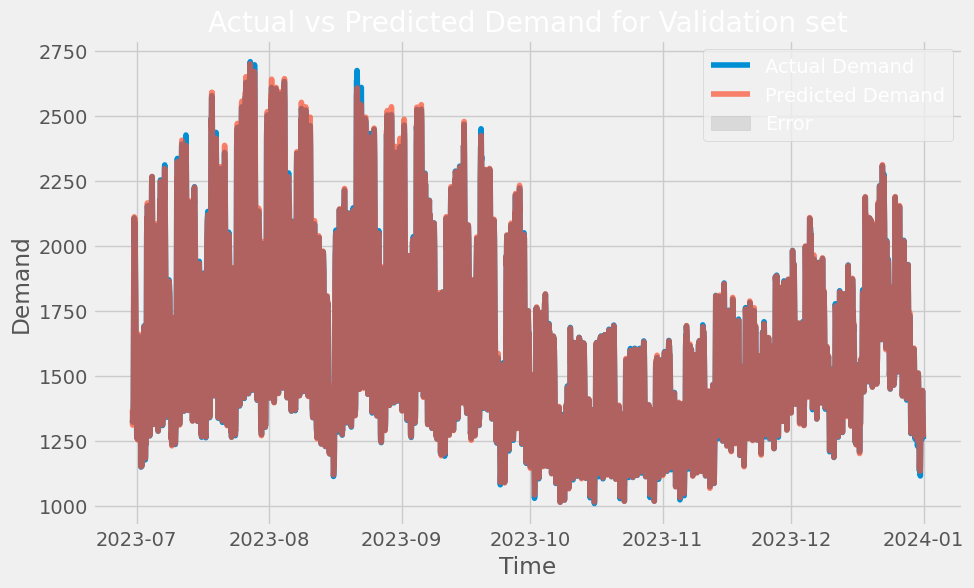

In [467]:
# Actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_true.index, y_true, label='Actual Demand')
plt.plot(y_true.index, y_pred, label='Predicted Demand', alpha=0.7)
plt.fill_between(y_true.index, y_true, y_pred, color='gray', alpha=0.2, label='Error')
plt.title('Actual vs Predicted Demand for Validation set')
plt.xlabel('Time')
plt.ylabel('Demand')
plt.legend()
plt.show()